# USS Reviews Comprehensive EDA Analysis

## Objective
This notebook provides comprehensive exploratory data analysis for Universal Studios Singapore (USS) reviews to support NLP-based business insights. The analysis covers multiple dimensions including temporal patterns, sentiment analysis, facility mentions, and visitor behavior patterns.

## Data Overview
- **Dataset**: USS_Reviews_Silver.csv
- **Records**: 4,411 customer reviews
- **Features**: integrated_review, stars, name, review, publishedAtDate, data_split, review_index
- **Structured Info Coverage**: ~77% of reviews contain visit_time and wait_time structured information

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [2]:
import os
import sys

# Ensure we're working from project root
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    os.chdir('..')
    print("Adjusted working directory to project root")

Adjusted working directory to project root


## 1. Data Loading and Basic Overview

In [3]:
# Define file paths using package and filename variables
DATA_PACKAGE = 'data/processed'
INPUT_FILENAME = 'USS_Reviews_Silver.csv'
INPUT_FILE_PATH = os.path.join(DATA_PACKAGE, INPUT_FILENAME)

# Load the dataset
df = pd.read_csv(INPUT_FILE_PATH)

# Basic dataset information
print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())

# Display sample data
print(f"\nFirst 3 rows:")
print(df.head(3))

print(f"\nDataset loaded successfully from: {INPUT_FILE_PATH}")

=== DATASET OVERVIEW ===
Dataset shape: (29412, 6)
Columns: ['integrated_review', 'stars', 'name', 'review', 'publishedAtDate', 'review_index']

Data types:
integrated_review    object
stars                 int64
name                 object
review               object
publishedAtDate      object
review_index          int64
dtype: object

Missing values:
integrated_review    0
stars                0
name                 0
review               0
publishedAtDate      0
review_index         0
dtype: int64

First 3 rows:
                                                                                     integrated_review  \
0       Nice lot if activities need entire day to cover all [VISIT_TIME: Weekday] [WAIT_TIME: No wait]   
1  Universal Studios Singapore offers an unforgettable experience packed with excitement, adventure...   
2  Mummy ride was great but cost way too much for express pass and food around the park. Transforme...   

   stars    name  \
0      4  user_0   
1      5  use

In [4]:
# Display sample records
print("=== SAMPLE RECORDS ===")
display(df.head())

# Check for differences between review and integrated_review
df['has_structured_info'] = df['integrated_review'] != df['review']
structured_coverage = df['has_structured_info'].mean() * 100
print(f"\nStructured information coverage: {structured_coverage:.1f}%")

=== SAMPLE RECORDS ===


,integrated_review,stars,name,review,publishedAtDate,review_index
0,Nice lot if activities need entire day to cover all [VISIT_TIME: Weekday] [WAIT_TIME: No wait],4,user_0,Nice lot if activities need entire day to cover all,2025-05-23,0
1,"Universal Studios Singapore offers an unforgettable experience packed with excitement, adventure...",5,user_1,"Universal Studios Singapore offers an unforgettable experience packed with excitement, adventure...",2025-05-23,1
2,Mummy ride was great but cost way too much for express pass and food around the park. Transforme...,2,user_2,Mummy ride was great but cost way too much for express pass and food around the park. Transforme...,2025-05-23,2
3,"We went there to enjoy the Minions. It's hot during the day, so you'll need to take precautions ...",4,user_3,"We went there to enjoy the Minions. It's hot during the day, so you'll need to take precautions ...",2025-05-23,3
4,Universal Studio's famous Playland Singapore. [VISIT_TIME: Weekday] [WAIT_TIME: Up to 10 min],5,user_4,Universal Studio's famous Playland Singapore.,2025-05-23,4



Structured information coverage: 25.5%


## 2. Star Rating Distribution Analysis

In [5]:
# Star rating distribution
star_counts = df['stars'].value_counts().sort_index()
star_percentages = df['stars'].value_counts(normalize=True).sort_index() * 100

print("=== STAR RATING DISTRIBUTION ===")
for star in range(1, 6):
    count = star_counts.get(star, 0)
    pct = star_percentages.get(star, 0)
    print(f"{star} stars: {count:,} reviews ({pct:.1f}%)")

# Calculate overall satisfaction metrics
avg_rating = df['stars'].mean()
positive_percentage = (df['stars'] >= 4).mean() * 100
negative_percentage = (df['stars'] <= 2).mean() * 100

print(f"\n=== SATISFACTION METRICS ===")
print(f"Average rating: {avg_rating:.2f} stars")
print(f"Positive reviews (4-5 stars): {positive_percentage:.1f}%")
print(f"Negative reviews (1-2 stars): {negative_percentage:.1f}%")

=== STAR RATING DISTRIBUTION ===
1 stars: 1,370 reviews (4.7%)
2 stars: 836 reviews (2.8%)
3 stars: 2,133 reviews (7.3%)
4 stars: 5,558 reviews (18.9%)
5 stars: 19,515 reviews (66.4%)

=== SATISFACTION METRICS ===
Average rating: 4.39 stars
Positive reviews (4-5 stars): 85.2%
Negative reviews (1-2 stars): 7.5%


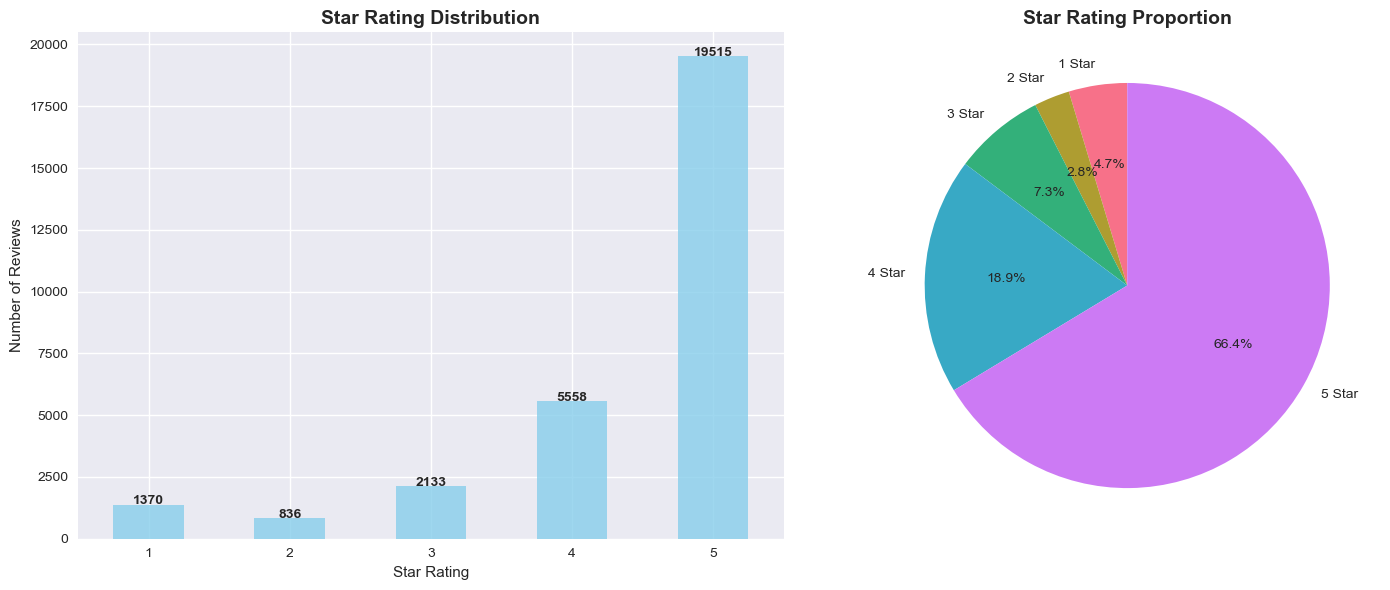

In [6]:
# Visualize star rating distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
star_counts.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)
ax1.set_title('Star Rating Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Star Rating')
ax1.set_ylabel('Number of Reviews')
ax1.tick_params(axis='x', rotation=0)

# Add value labels on bars
for i, v in enumerate(star_counts.values):
    ax1.text(i, v + 20, str(v), ha='center', fontweight='bold')

# Pie chart
ax2.pie(star_counts.values, labels=[f'{i} Star' for i in star_counts.index], 
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette("husl", len(star_counts)))
ax2.set_title('Star Rating Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Structured Information Extraction and Analysis

In [7]:
# Extract structured information from integrated_review field
def extract_structured_info(integrated_review):
    """Extract VISIT_TIME and WAIT_TIME from integrated review text"""
    visit_time_match = re.search(r'\[VISIT_TIME: ([^\]]+)\]', integrated_review)
    wait_time_match = re.search(r'\[WAIT_TIME: ([^\]]+)\]', integrated_review)
    
    return {
        'visit_time': visit_time_match.group(1) if visit_time_match else None,
        'wait_time': wait_time_match.group(1) if wait_time_match else None
    }

# Apply extraction to all records
structured_info = df['integrated_review'].apply(extract_structured_info)
df['visit_time'] = [info['visit_time'] for info in structured_info]
df['wait_time'] = [info['wait_time'] for info in structured_info]

# Count reviews with visit time and wait time information
total_reviews = len(df)
reviews_with_visit_time = df['visit_time'].notna().sum()
reviews_with_wait_time = df['wait_time'].notna().sum()

print("=== OVERALL COVERAGE ===")
print(f"Total reviews: {total_reviews:,}")
print(f"Reviews with visit time info: {reviews_with_visit_time:,} ({reviews_with_visit_time/total_reviews*100:.1f}%)")
print(f"Reviews with wait time info: {reviews_with_wait_time:,} ({reviews_with_wait_time/total_reviews*100:.1f}%)")
print()

# Analyze visit time patterns (among reviews with visit time info)
if reviews_with_visit_time > 0:
    visit_time_counts = df['visit_time'].value_counts()
    print("=== VISIT TIME PATTERNS ===")
    for time_type, count in visit_time_counts.items():
        pct = count / reviews_with_visit_time * 100
        print(f"{time_type}: {count:,} reviews ({pct:.1f}%)")
    print()

# Analyze wait time patterns (among reviews with wait time info)
if reviews_with_wait_time > 0:
    wait_time_counts = df['wait_time'].value_counts()
    print("=== WAIT TIME PATTERNS ===")
    for wait_time, count in wait_time_counts.items():
        pct = count / reviews_with_wait_time * 100
        print(f"{wait_time}: {count:,} reviews ({pct:.1f}%)")
else:
    print("=== WAIT TIME PATTERNS ===")
    print("No wait time information found in the dataset")

=== OVERALL COVERAGE ===
Total reviews: 29,412
Reviews with visit time info: 7,282 (24.8%)
Reviews with wait time info: 6,982 (23.7%)

=== VISIT TIME PATTERNS ===
Weekday: 4,674 reviews (64.2%)
Weekend: 2,099 reviews (28.8%)
Public holiday: 509 reviews (7.0%)

=== WAIT TIME PATTERNS ===
No wait: 2,625 reviews (37.6%)
Up to 10 min: 1,404 reviews (20.1%)
1030 min: 1,304 reviews (18.7%)
1 hr: 853 reviews (12.2%)
3060 min: 796 reviews (11.4%)


## 4. Time-Satisfaction Correlation Analysis
### Key Finding: This analysis supports the Time-Sensitive Satisfaction Prediction model recommendation

In [8]:
# Analyze sentiment by visit time
visit_time_sentiment = df.groupby('visit_time')['stars'].agg(['mean', 'count', 'std']).round(2)
visit_time_sentiment = visit_time_sentiment.dropna().sort_values('mean', ascending=False)

print("=== SENTIMENT BY VISIT TIME ===")
print(visit_time_sentiment)

# Analyze sentiment by wait time
wait_time_sentiment = df.groupby('wait_time')['stars'].agg(['mean', 'count', 'std']).round(2)
wait_time_sentiment = wait_time_sentiment.dropna().sort_values('count', ascending=False)

print("\n=== SENTIMENT BY WAIT TIME ===")
print(wait_time_sentiment)

=== SENTIMENT BY VISIT TIME ===
                mean  count   std
visit_time                       
Public holiday  4.46    509  0.99
Weekend         4.38   2099  1.06
Weekday         4.14   4674  1.26

=== SENTIMENT BY WAIT TIME ===
              mean  count   std
wait_time                      
No wait       4.48   2625  0.95
Up to 10 min  4.44   1404  0.97
1030 min      4.32   1304  1.08
1 hr          3.15    853  1.64
3060 min      3.97    796  1.36


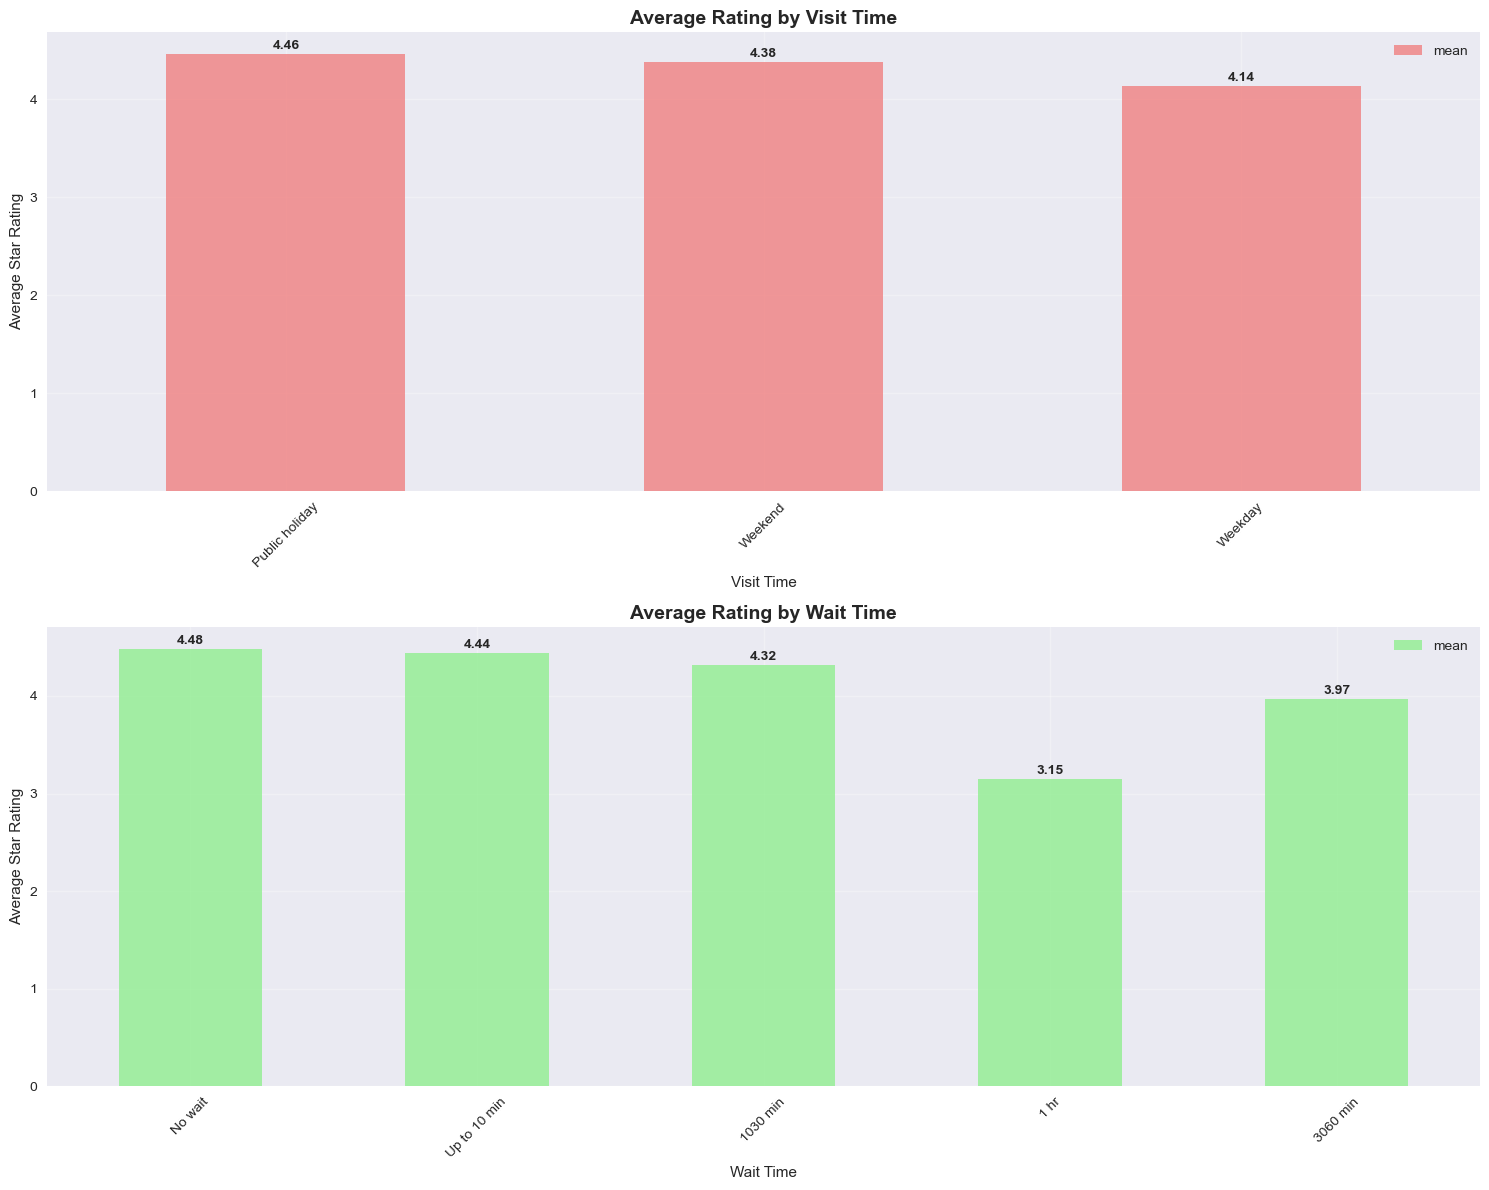


=== CRITICAL INSIGHTS ===
Best satisfaction: Public holidays (4.46 stars)
Worst wait time impact: 3.15 stars
Critical wait threshold: 1 hr wait time shows significant satisfaction drop


In [9]:
# Visualize time-satisfaction relationships
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Visit time vs satisfaction
visit_time_sentiment.plot(y='mean', kind='bar', ax=ax1, color='lightcoral', alpha=0.8)
ax1.set_title('Average Rating by Visit Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Average Star Rating')
ax1.set_xlabel('Visit Time')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(visit_time_sentiment['mean'].values):
    ax1.text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')

# Wait time vs satisfaction (top 8 categories)
top_wait_times = wait_time_sentiment.head(8)
top_wait_times.plot(y='mean', kind='bar', ax=ax2, color='lightgreen', alpha=0.8)
ax2.set_title('Average Rating by Wait Time', fontsize=14, fontweight='bold')
ax2.set_ylabel('Average Star Rating')
ax2.set_xlabel('Wait Time')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(top_wait_times['mean'].values):
    ax2.text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Identify critical wait time threshold
print("\n=== CRITICAL INSIGHTS ===")
print(f"Best satisfaction: Public holidays ({visit_time_sentiment.loc['Public holiday', 'mean']:.2f} stars)")
print(f"Worst wait time impact: {wait_time_sentiment.loc[wait_time_sentiment['mean'].idxmin(), 'mean']:.2f} stars")
print(f"Critical wait threshold: 1 hr wait time shows significant satisfaction drop")

## 5. Review Length and Content Analysis

In [10]:
# Calculate review length statistics
df['review_length'] = df['review'].str.len()
df['word_count'] = df['review'].str.split().str.len()

# Analyze review length by star rating
length_by_stars = df.groupby('stars')[['review_length', 'word_count']].agg(['mean', 'median', 'std']).round(1)

print("=== REVIEW LENGTH BY STAR RATING ===")
print(length_by_stars)

# Overall statistics
print(f"\n=== OVERALL REVIEW STATISTICS ===")
print(f"Average review length: {df['review_length'].mean():.0f} characters")
print(f"Average word count: {df['word_count'].mean():.0f} words")
print(f"Median review length: {df['review_length'].median():.0f} characters")
print(f"Longest review: {df['review_length'].max():,} characters")
print(f"Shortest review: {df['review_length'].min()} characters")

=== REVIEW LENGTH BY STAR RATING ===
      review_length               word_count             
               mean median    std       mean median   std
stars                                                    
1             330.2  216.5  375.0       60.4   40.0  69.2
2             295.5  183.0  359.0       53.8   33.0  65.1
3             225.6  126.0  310.3       41.2   23.0  56.0
4             179.2   95.0  246.1       32.7   17.0  44.4
5             135.7   61.0  226.4       24.4   11.0  39.8

=== OVERALL REVIEW STATISTICS ===
Average review length: 164 characters
Average word count: 30 words
Median review length: 76 characters
Longest review: 4,183 characters
Shortest review: 1 characters


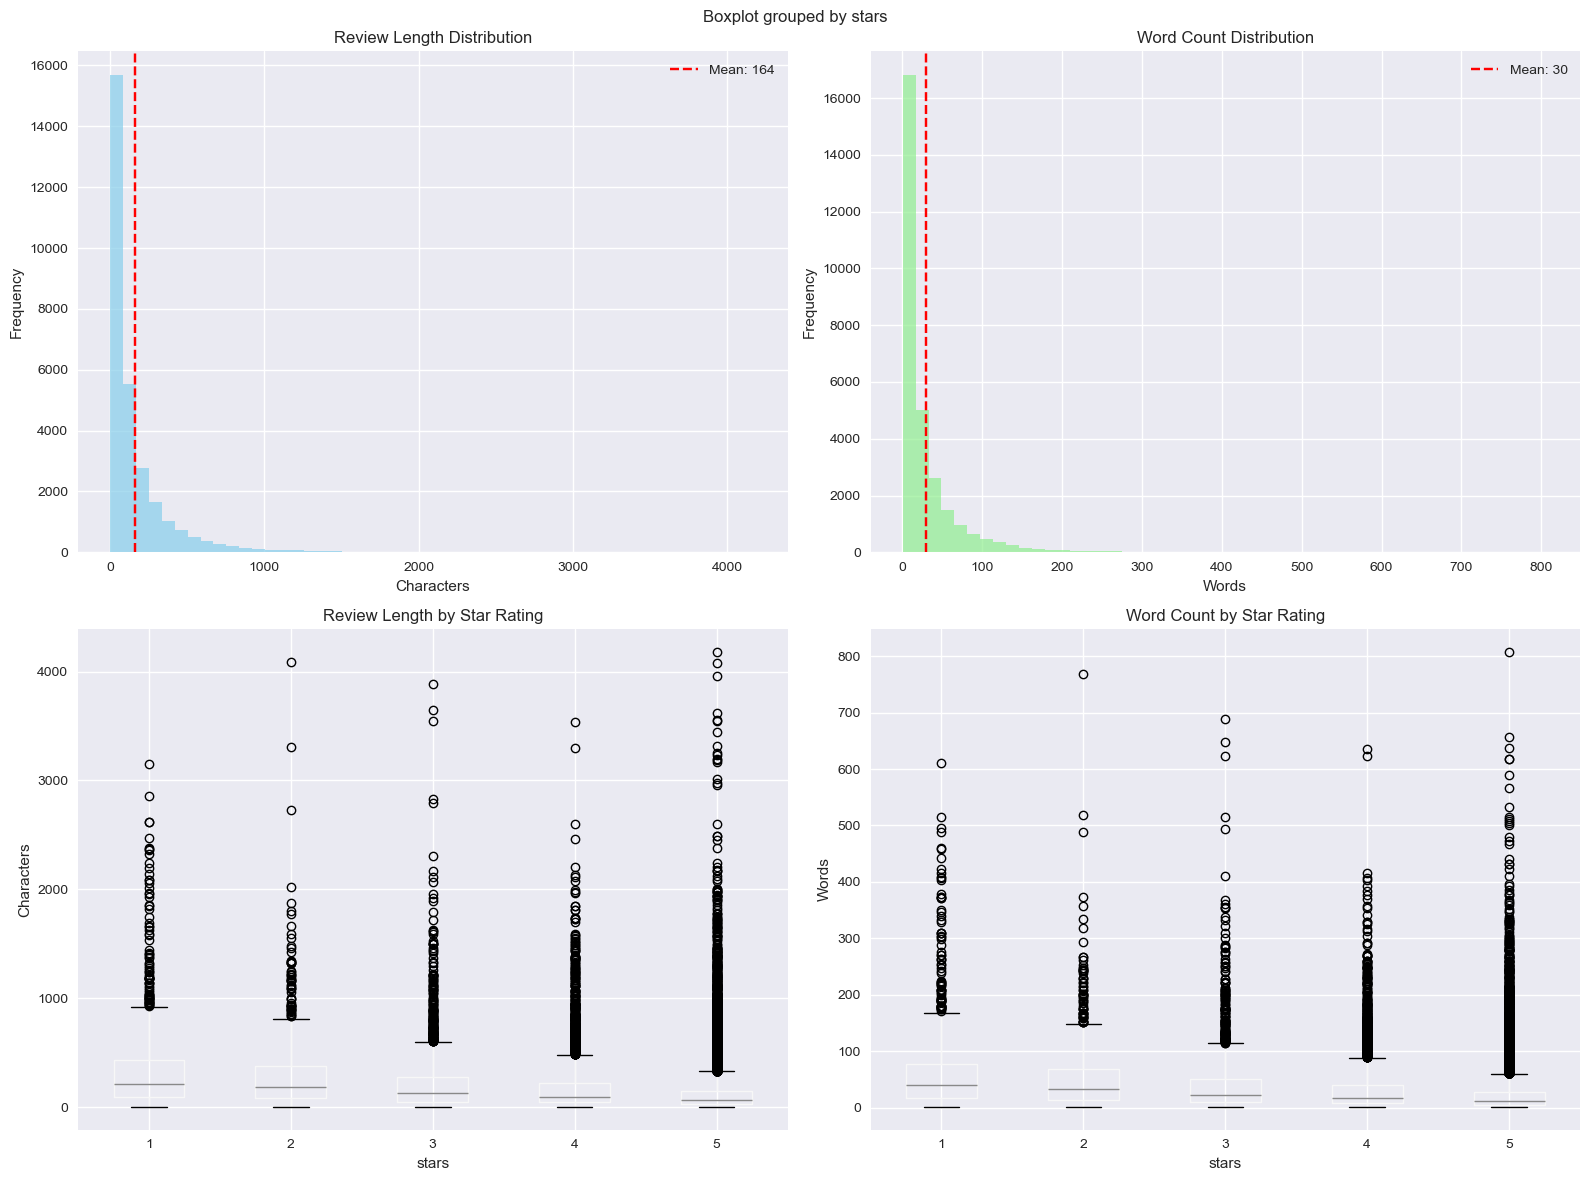

In [11]:
# Visualize review length patterns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Review length distribution
df['review_length'].hist(bins=50, ax=ax1, alpha=0.7, color='skyblue')
ax1.set_title('Review Length Distribution')
ax1.set_xlabel('Characters')
ax1.set_ylabel('Frequency')
ax1.axvline(df['review_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["review_length"].mean():.0f}')
ax1.legend()

# Word count distribution
df['word_count'].hist(bins=50, ax=ax2, alpha=0.7, color='lightgreen')
ax2.set_title('Word Count Distribution')
ax2.set_xlabel('Words')
ax2.set_ylabel('Frequency')
ax2.axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["word_count"].mean():.0f}')
ax2.legend()

# Review length by star rating
df.boxplot(column='review_length', by='stars', ax=ax3)
ax3.set_title('Review Length by Star Rating')
ax3.set_ylabel('Characters')

# Word count by star rating
df.boxplot(column='word_count', by='stars', ax=ax4)
ax4.set_title('Word Count by Star Rating')
ax4.set_ylabel('Words')

plt.tight_layout()
plt.show()

## 6. Facility and Aspect Mention Analysis
### This supports the Multi-dimensional Experience Sentiment Analysis recommendation

In [ ]:
# Define facility and aspect keywords based on data analysis
facility_keywords = {
    'Rides & Attractions': [
        # Major rides from JSON
        'transformers', 'mummy', 'revenge of the mummy', 'battlestar galactica', 'human', 'cylon',
        'jurassic park rapids', 'canopy flyer', 'dino soarin', 'treasure hunters',
        'enchanted airways', 'magic potion spin', 'puss in boots', 'giant journey',
        'sesame street spaghetti space chase', 'accelerator', 'despicable me minion mayhem',
        'buggie boogie', 'silly swirly', 'sesame street goes bollywood',
        # General terms
        'ride', 'rides', 'attraction', 'attractions', 'roller coaster', 'thrill'
    ],
    
    'Shows & Entertainment': [
        # Specific shows from JSON
        'waterworld', 'shrek 4d', 'lights camera action', 'lake hollywood spectacular',
        'transformers voices of cybertron', 'donkey live', 'happily ever after',
        'trolls hug time jubilee', 'minute of minion mayhem', 'minion dance party',
        'raptor encounter', 'hatched featuring dr rodney', 'rhythm truck',
        # General terms
        'show', 'shows', 'entertainment', 'performance', 'theater', 'spectacle'
    ],
    
    'Food & Beverage': [
        # Specific dining from JSON
        'mel s drive in', 'discovery food court', 'kt s grill', 'loui s ny pizza',
        'friar s good food', 'goldilocks', 'starbucks', 'planet yen', 'starbot café',
        'ice cream stand', 'pop a nana', 'frozen fuel', 'fossil fuels',
        # General terms
        'food', 'restaurant', 'dining', 'eat', 'meal', 'lunch', 'dinner', 'snack',
        'drink', 'beverage', 'coffee', 'pizza', 'ice cream', 'food court'
    ],
    
    'Shopping & Retail': [
        # Specific stores from JSON
        'universal studios store', 'minion mart', 'candylicious', 'hello kitty studio',
        'transformers supply vault', 'fairy godmother s potion shop', 'dino store',
        'sweet surrender', 'pop store', 'fun store', 'big bird s emporium',
        # General terms
        'shop', 'shopping', 'store', 'gift shop', 'souvenir', 'merchandise', 'retail'
    ],
    
    'Theme Areas': [
        # Specific areas from JSON
        'minion land', 'hollywood', 'new york', 'sci-fi city', 'ancient egypt', 
        'lost world', 'far far away', 'jurassic park', 'sesame street',
        # General terms
        'area', 'zone', 'land', 'section', 'theme'
    ],
    
    'Service & Staff': [
        'staff', 'service', 'employee', 'crew', 'guide', 'worker', 'cast member',
        'helpful', 'friendly', 'rude', 'professional', 'customer service'
    ],
    
    'Wait & Queue Management': [
        'wait', 'queue', 'line', 'crowd', 'busy', 'express', 'fast pass', 'single rider',
        'waiting time', 'long wait', 'short wait', 'skip line'
    ],
    
    'Pricing & Value': [
        'expensive', 'cheap', 'worth', 'money', 'price', 'cost', 'ticket', 'value',
        'overpriced', 'reasonable', 'affordable', 'budget'
    ],
    
    'Facilities & Amenities': [
        # From others JSON
        'lockers', 'restrooms', 'first aid', 'baby care', 'child swap', 
        'stroller', 'wheelchair', 'guest services', 'atms', 'prayer room',
        'smoking areas', 'accessible parking', 'shuttle service', 'charging stations', 'wifi',
        # General terms
        'parking', 'bathroom', 'toilet', 'facility', 'amenity'
    ],
    
    'Games & Activities': [
        # Game booths from JSON
        'ba na na cabana', 'space killer', 'sci fi games', 'lost world games',
        # General terms
        'game', 'games', 'activity', 'carnival', 'booth', 'arcade'
    ],
    
    'Experience Quality': [
        'fun', 'exciting', 'boring', 'amazing', 'terrible', 'awesome', 'disappointing',
        'thrilling', 'scary', 'enjoyable', 'memorable', 'fantastic', 'awful'
    ],
    
    'Visitor Demographics': [
        'family', 'kid', 'children', 'adult', 'teenager', 'child', 'baby', 'toddler',
        'parents', 'couples', 'seniors', 'group'
    ]
}

# Count unique reviews mentioning each category (not total keyword occurrences)
category_reviews = {}
for category, keywords in facility_keywords.items():
    # Create boolean mask for reviews containing any keyword from this category
    category_mask = df['review'].str.lower().str.contains('|'.join(keywords), na=False, regex=True)
    # Count unique reviews that mention this category
    unique_reviews = category_mask.sum()
    category_reviews[category] = unique_reviews

print("=== FACILITY/ASPECT MENTION FREQUENCY ===")
print("(Based on number of unique reviews mentioning each category)")
for category, count in sorted(category_reviews.items(), key=lambda x: x[1], reverse=True):
    pct = count / len(df) * 100
    print(f"{category}: {count:,} reviews ({pct:.1f}% of total reviews)")

=== FACILITY/ASPECT MENTION FREQUENCY ===
(Based on number of unique reviews mentioning each category)
Rides & Attractions: 11,502 reviews (39.1% of total reviews)
Experience Quality: 8,967 reviews (30.5% of total reviews)
Wait & Queue Management: 8,893 reviews (30.2% of total reviews)
Food & Beverage: 6,797 reviews (23.1% of total reviews)
Pricing & Value: 6,357 reviews (21.6% of total reviews)
Visitor Demographics: 5,048 reviews (17.2% of total reviews)
Theme Areas: 4,309 reviews (14.7% of total reviews)
Shows & Entertainment: 2,959 reviews (10.1% of total reviews)
Service & Staff: 1,621 reviews (5.5% of total reviews)
Shopping & Retail: 956 reviews (3.3% of total reviews)
Games & Activities: 947 reviews (3.2% of total reviews)
Facilities & Amenities: 699 reviews (2.4% of total reviews)



=== SPECIFIC ATTRACTION MENTIONS ===
(Based on number of reviews mentioning each attraction)
Transformers: 1,936 reviews (6.6% of total reviews)
Mummy: 1,712 reviews (5.8% of total reviews)
Jurassic: 959 reviews (3.3% of total reviews)
Galactica: 518 reviews (1.8% of total reviews)
Minion: 452 reviews (1.5% of total reviews)
Battlestar: 445 reviews (1.5% of total reviews)
Puss In Boots: 72 reviews (0.2% of total reviews)
Canopy Flyer: 65 reviews (0.2% of total reviews)


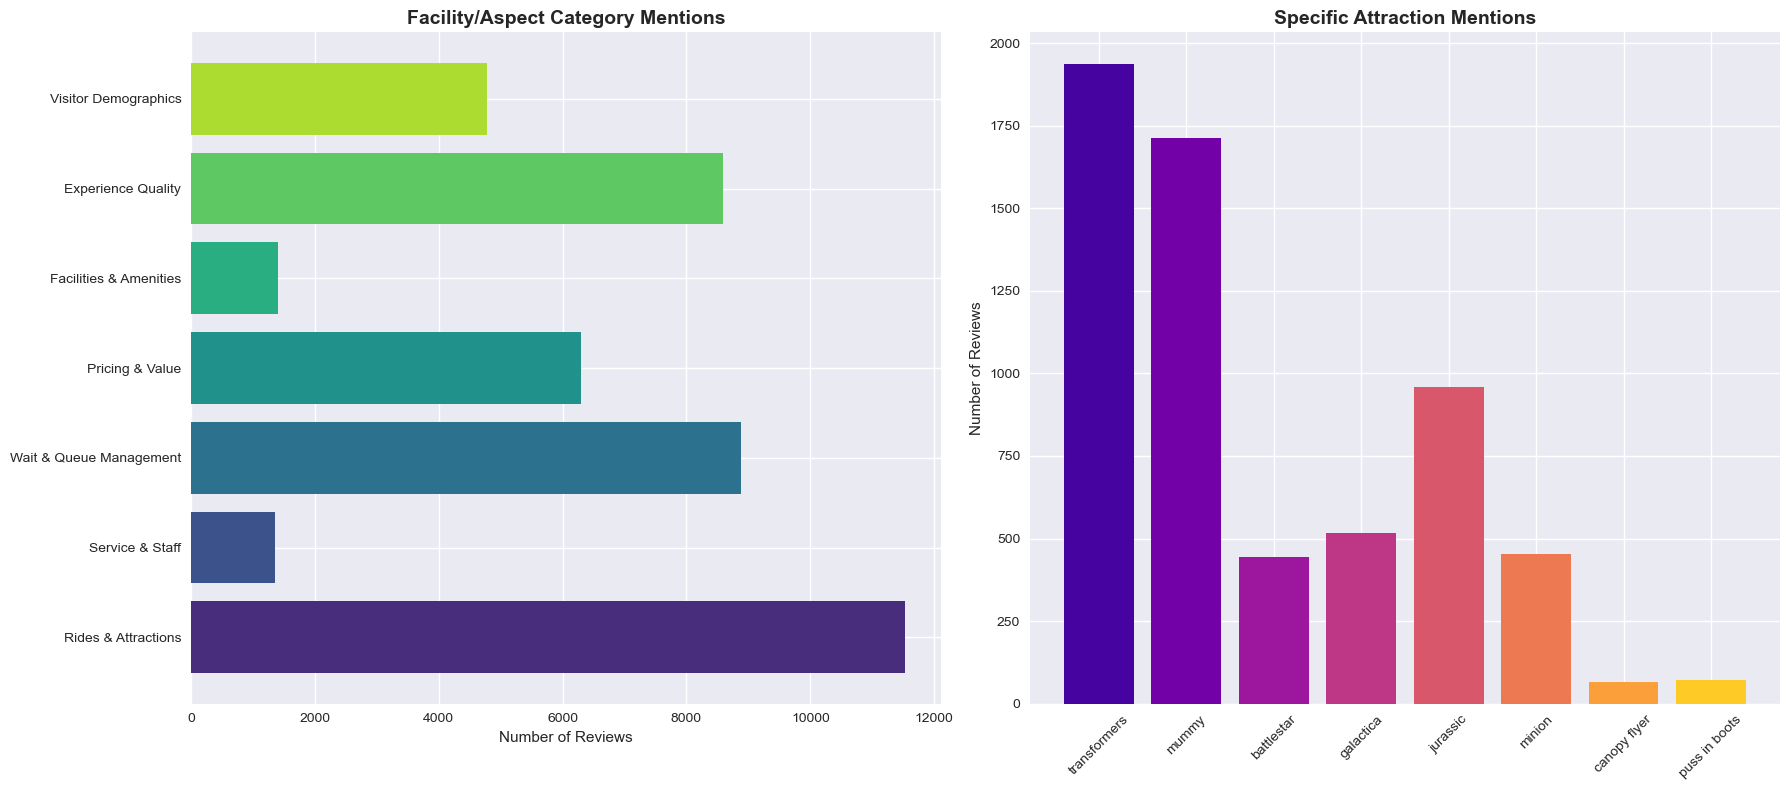

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze specific facility mentions
specific_facilities = ['transformers', 'mummy', 'battlestar', 'galactica', 'jurassic', 
                      'minion', 'canopy flyer', 'puss in boots']

# Count reviews mentioning each specific facility
facility_reviews = {}
for facility in specific_facilities:
    facility_reviews[facility] = df['review'].str.lower().str.contains(facility, na=False).sum()

print("\n=== SPECIFIC ATTRACTION MENTIONS ===")
print("(Based on number of reviews mentioning each attraction)")
for facility, count in sorted(facility_reviews.items(), key=lambda x: x[1], reverse=True):
    pct = count / len(df) * 100
    print(f"{facility.title()}: {count:,} reviews ({pct:.1f}% of total reviews)")

# Visualize facility mentions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Category mentions (use the corrected variable name)
categories = list(category_reviews.keys())
counts = list(category_reviews.values())
ax1.barh(categories, counts, color=sns.color_palette("viridis", len(categories)))
ax1.set_title('Facility/Aspect Category Mentions', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Reviews')

# Specific facility mentions
facilities = list(facility_reviews.keys())
f_counts = list(facility_reviews.values())
ax2.bar(facilities, f_counts, color=sns.color_palette("plasma", len(facilities)))
ax2.set_title('Specific Attraction Mentions', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Reviews')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Visitor Type and Demographic Analysis
### This supports the Visitor Segmentation & Preference Analysis recommendation

In [14]:
# Identify visitor types based on review content
visitor_indicators = {
    'Family Visitors': ['family', 'kid', 'children', 'child', 'baby', 'daughter', 'son'],
    'Young Adults/Thrill Seekers': ['thrill', 'exciting', 'adrenaline', 'intense', 'scary', 'extreme'],
    'Couples/Romance': ['romantic', 'date', 'boyfriend', 'girlfriend', 'couple', 'together'],
    'Tourist/International': ['tourist', 'vacation', 'holiday', 'visit', 'singapore', 'sentosa'],
    'Repeat Visitors': ['again', 'second time', 'return', 'back', 'previous', 'last time'],
    'Budget Conscious': ['expensive', 'costly', 'cheap', 'budget', 'money', 'worth']
}

# Count unique reviews mentioning each visitor type (not total keyword occurrences)
visitor_type_reviews = {}
for visitor_type, indicators in visitor_indicators.items():
    # Create boolean mask for reviews containing any indicator from this visitor type
    visitor_mask = df['review'].str.lower().str.contains('|'.join(indicators), na=False, regex=True)
    # Count unique reviews that mention this visitor type
    unique_reviews = visitor_mask.sum()
    visitor_type_reviews[visitor_type] = unique_reviews

print("=== VISITOR TYPE INDICATORS ===")
print("(Based on number of unique reviews mentioning each visitor type)")
for visitor_type, count in sorted(visitor_type_reviews.items(), key=lambda x: x[1], reverse=True):
    pct = count / len(df) * 100
    print(f"{visitor_type}: {count:,} reviews ({pct:.1f}% coverage)")

# Analyze satisfaction by visitor type (simplified classification)
df['is_family'] = df['review'].str.lower().str.contains('family|kid|children|child', na=False, regex=True)
df['is_budget_conscious'] = df['review'].str.lower().str.contains('expensive|costly|cheap|budget|money|worth', na=False, regex=True)
df['mentions_thrill'] = df['review'].str.lower().str.contains('thrill|exciting|adrenaline|intense|scary', na=False, regex=True)

# Calculate satisfaction metrics for each visitor type
visitor_satisfaction = pd.DataFrame({
    'Family Visitors': [df[df['is_family']]['stars'].mean(), df['is_family'].sum()],
    'Budget Conscious': [df[df['is_budget_conscious']]['stars'].mean(), df['is_budget_conscious'].sum()],
    'Thrill Seekers': [df[df['mentions_thrill']]['stars'].mean(), df['mentions_thrill'].sum()],
    'Others': [df[~(df['is_family'] | df['is_budget_conscious'] | df['mentions_thrill'])]['stars'].mean(), 
              (~(df['is_family'] | df['is_budget_conscious'] | df['mentions_thrill'])).sum()]
}, index=['Avg_Rating', 'Count'])

print("\n=== SATISFACTION BY VISITOR TYPE ===")
print(visitor_satisfaction.round(2))

=== VISITOR TYPE INDICATORS ===
(Based on number of unique reviews mentioning each visitor type)
Tourist/International: 7,811 reviews (26.6% coverage)
Family Visitors: 5,550 reviews (18.9% coverage)
Budget Conscious: 3,946 reviews (13.4% coverage)
Young Adults/Thrill Seekers: 2,125 reviews (7.2% coverage)
Repeat Visitors: 1,826 reviews (6.2% coverage)
Couples/Romance: 493 reviews (1.7% coverage)

=== SATISFACTION BY VISITOR TYPE ===
            Family Visitors  Budget Conscious  Thrill Seekers    Others
Avg_Rating             4.46              3.92            4.59      4.44
Count               4618.00           3946.00         1821.00  20469.00


## 8. Price Sensitivity and Value Perception Analysis
### This supports the Value Perception vs Price Sensitivity Analysis recommendation

In [15]:
import pandas as pd

# Analyze price-related sentiment
price_keywords = {
    'Expensive/Costly': ['expensive', 'costly', 'overpriced', 'pricey'],
    'Worth/Value': ['worth', 'value', 'worthwhile'],
    'Cheap/Affordable': ['cheap', 'affordable', 'reasonable'],
    'Money General': ['money', 'cost', 'price', 'pay', 'paid']
}

# Count reviews mentioning each price category and analyze sentiment
price_sentiment_analysis = {}
for category, keywords in price_keywords.items():
    # Create boolean mask for reviews containing any keyword from this category
    mask = df['review'].str.lower().str.contains('|'.join(keywords), na=False, regex=True)
    
    if mask.sum() > 0:
        avg_rating = df[mask]['stars'].mean()
        count = mask.sum()
        price_sentiment_analysis[category] = {'avg_rating': avg_rating, 'count': count}

print("=== PRICE SENTIMENT ANALYSIS ===")
print("(Based on number of unique reviews mentioning each price category)")
for category, data in price_sentiment_analysis.items():
    print(f"{category}: {data['avg_rating']:.2f} stars (n={data['count']})")

# Analyze express pass mentions
express_mask = df['review'].str.lower().str.contains('express|fast pass', na=False, regex=True)
express_satisfaction = df[express_mask]['stars'].mean()
express_count = express_mask.sum()

print(f"\nExpress Pass mentions: {express_satisfaction:.2f} stars (n={express_count})")

# Value perception analysis
worth_positive = df['review'].str.lower().str.contains('worth it|worthwhile|worth the', na=False, regex=True)
worth_negative = df['review'].str.lower().str.contains('not worth|waste.*money', na=False, regex=True)

print(f"\n=== VALUE PERCEPTION ===")
print(f"Positive value perception: {df[worth_positive]['stars'].mean():.2f} stars (n={worth_positive.sum()})")
print(f"Negative value perception: {df[worth_negative]['stars'].mean():.2f} stars (n={worth_negative.sum()})")

=== PRICE SENTIMENT ANALYSIS ===
(Based on number of unique reviews mentioning each price category)
Expensive/Costly: 3.79 stars (n=1682)
Worth/Value: 4.12 stars (n=2150)
Cheap/Affordable: 4.23 stars (n=389)
Money General: 3.56 stars (n=2988)

Express Pass mentions: 4.09 stars (n=3254)

=== VALUE PERCEPTION ===
Positive value perception: 4.05 stars (n=1035)
Negative value perception: 2.06 stars (n=503)


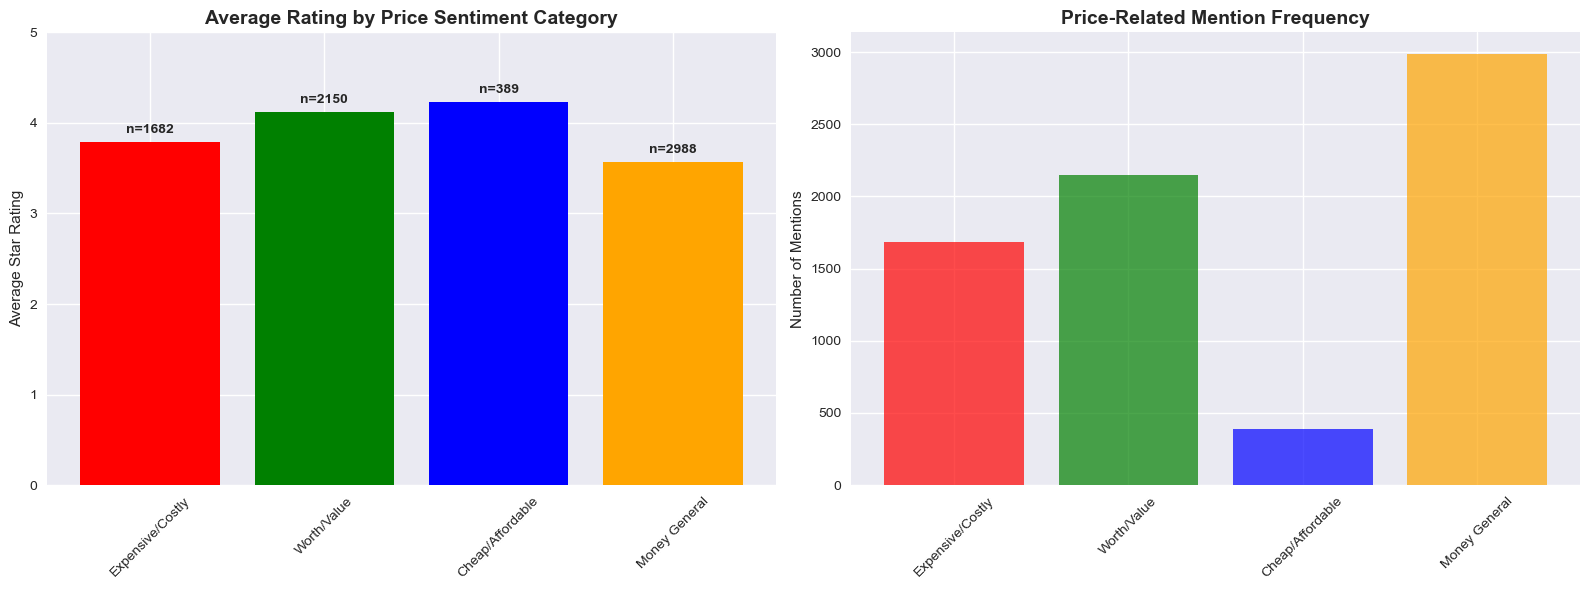

In [16]:
# Visualize price sensitivity analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Price sentiment by category
categories = list(price_sentiment_analysis.keys())
ratings = [data['avg_rating'] for data in price_sentiment_analysis.values()]
counts = [data['count'] for data in price_sentiment_analysis.values()]

bars = ax1.bar(categories, ratings, color=['red', 'green', 'blue', 'orange'])
ax1.set_title('Average Rating by Price Sentiment Category', fontsize=14, fontweight='bold')
ax1.set_ylabel('Average Star Rating')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, 5)

# Add count labels on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'n={count}', ha='center', fontweight='bold')

# Mention frequency
ax2.bar(categories, counts, color=['red', 'green', 'blue', 'orange'], alpha=0.7)
ax2.set_title('Price-Related Mention Frequency', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Mentions')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 9. Monthly Service Quality Evolution Analysis

=== MONTHLY SERVICE QUALITY EVOLUTION ===
            avg_rating  review_count  rating_std  rating_volatility  \
year_month                                                            
2018-07          4.381            97       1.065              0.243   
2018-08          4.411           855       1.002              0.227   
2018-09          4.578           778       0.789              0.172   
2018-10          4.583           797       0.770              0.168   
2018-11          4.598           758       0.776              0.169   
...                ...           ...         ...                ...   
2025-01          4.355           313       1.132              0.260   
2025-02          4.396           255       1.099              0.250   
2025-03          4.455           297       0.996              0.224   
2025-04          4.321           349       1.160              0.268   
2025-05          4.197           305       1.278              0.305   

            trend_change  
year_mo

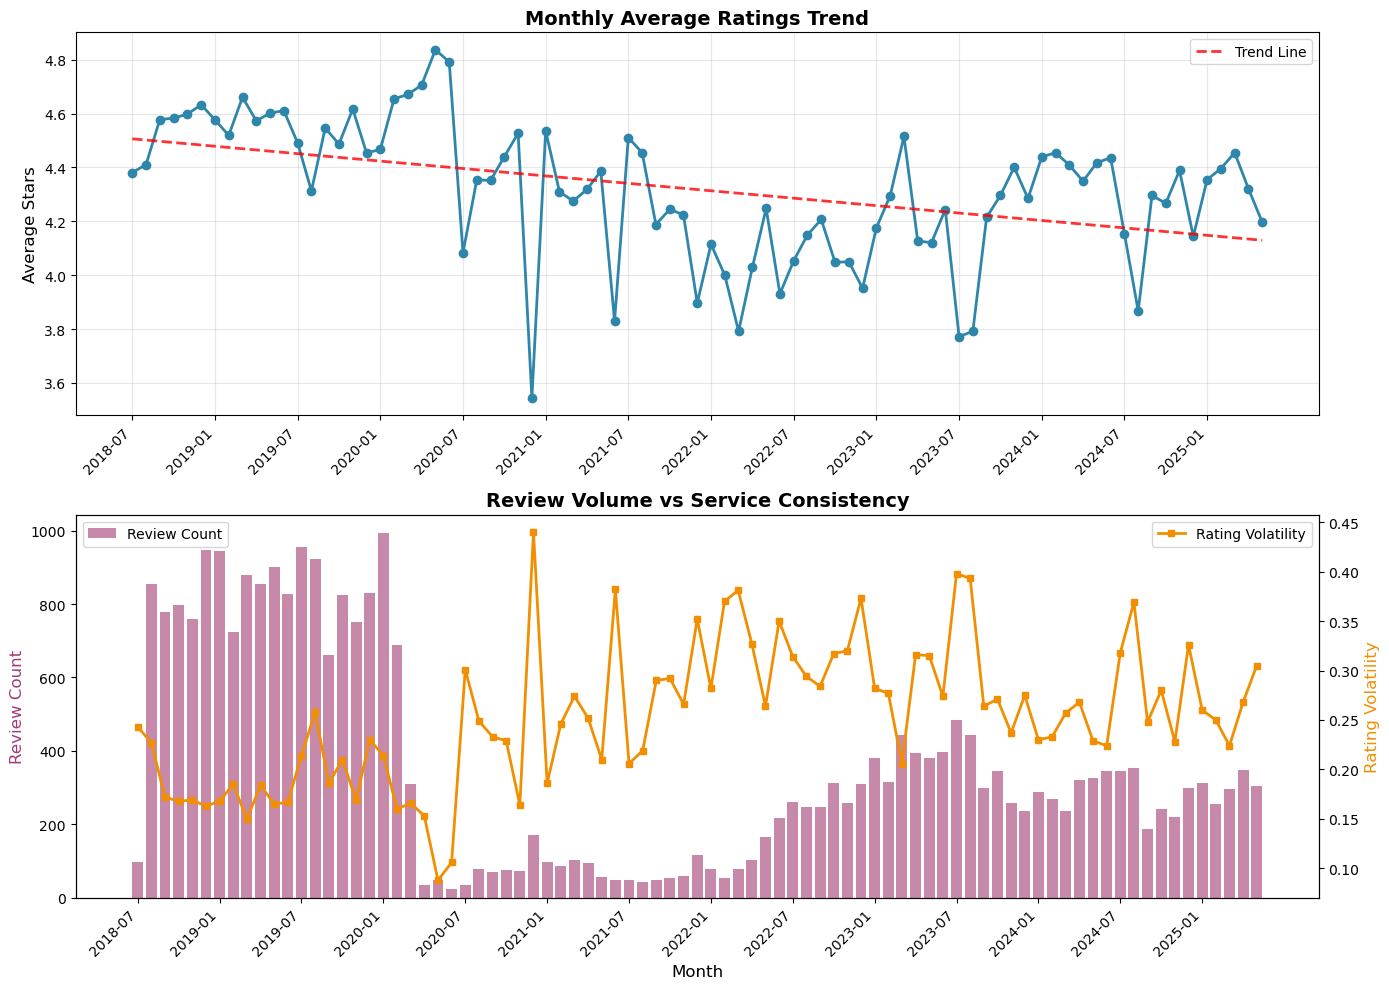

In [ ]:
if 'publishedAtDate' in df.columns:
    try:
        # Convert date and extract temporal features
        df['date'] = pd.to_datetime(df['publishedAtDate'])
        df['year_month'] = df['date'].dt.to_period('M')
        
        # Monthly sentiment and quality metrics
        monthly_analysis = df.groupby('year_month')['stars'].agg(['mean', 'count', 'std']).round(3)
        monthly_analysis.columns = ['avg_rating', 'review_count', 'rating_std']
        
        # Calculate service quality indicators
        monthly_analysis['rating_volatility'] = (monthly_analysis['rating_std'] / monthly_analysis['avg_rating']).round(3)
        monthly_analysis['trend_change'] = monthly_analysis['avg_rating'].pct_change().round(3)
        
        print("=== MONTHLY SERVICE QUALITY EVOLUTION ===")
        print(monthly_analysis)
        
        # Identify best and worst performing months
        best_month = monthly_analysis['avg_rating'].idxmax()
        worst_month = monthly_analysis['avg_rating'].idxmin()
        
        print(f"\n=== SERVICE QUALITY INSIGHTS ===")
        print(f"Best performing month: {best_month} (Rating: {monthly_analysis.loc[best_month, 'avg_rating']:.2f})")
        print(f"Worst performing month: {worst_month} (Rating: {monthly_analysis.loc[worst_month, 'avg_rating']:.2f})")
        
        # Overall trend analysis
        overall_trend = monthly_analysis['avg_rating'].corr(range(len(monthly_analysis)))
        trend_direction = "Improving" if overall_trend > 0.1 else "Declining" if overall_trend < -0.1 else "Stable"
        print(f"Overall service trend: {trend_direction} (correlation: {overall_trend:.3f})")
        
        # Recent performance (last 3 months)
        recent_avg = monthly_analysis['avg_rating'].tail(3).mean()
        print(f"Recent 3-month average: {recent_avg:.2f} stars")
        
        # Service consistency analysis
        high_volatility_months = monthly_analysis[monthly_analysis['rating_volatility'] > monthly_analysis['rating_volatility'].mean()]
        print(f"\nMonths with high service inconsistency: {len(high_volatility_months)}")
        
    except:
        print("\nTemporal analysis not possible with current date format")

try:
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Monthly average ratings with trend line
    months_str = [str(m) for m in monthly_analysis.index]
    ax1.plot(range(len(monthly_analysis)), monthly_analysis['avg_rating'], 
             marker='o', linewidth=2, markersize=6, color='#2E86AB')
    ax1.set_title('Monthly Average Ratings Trend', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Average Stars', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(range(len(monthly_analysis)), monthly_analysis['avg_rating'], 1)
    p = np.poly1d(z)
    ax1.plot(range(len(monthly_analysis)), p(range(len(monthly_analysis))), 
             "--", alpha=0.8, color='red', linewidth=2, label=f'Trend Line')
    ax1.legend()
    
    step = max(1, len(months_str) // 12)  
    tick_positions = range(0, len(months_str), step)
    tick_labels = [months_str[i] for i in tick_positions]
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(tick_labels, rotation=45, ha='right')
    
    # Plot 2: Review volume with volatility overlay
    bars = ax2.bar(range(len(monthly_analysis)), monthly_analysis['review_count'], 
                   alpha=0.6, color='#A23B72', label='Review Count')
    
    # Secondary y-axis for volatility
    ax2_twin = ax2.twinx()
    line = ax2_twin.plot(range(len(monthly_analysis)), monthly_analysis['rating_volatility'], 
                        color='#F18F01', marker='s', linewidth=2, markersize=4, 
                        label='Rating Volatility')
    
    ax2.set_title('Review Volume vs Service Consistency', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Review Count', color='#A23B72', fontsize=12)
    ax2_twin.set_ylabel('Rating Volatility', color='#F18F01', fontsize=12)
    ax2.set_xlabel('Month', fontsize=12)
    
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels(tick_labels, rotation=45, ha='right')
    
    ax2.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Visualization error: {e}")

## 10. Negative Experience Pattern Analysis
### This supports the Negative Experience Early Warning System recommendation

In [25]:
# Create DataFrames for negative and positive reviews
negative_reviews = df[df['stars'] <= 2]  # DataFrame for negative reviews
positive_reviews = df[df['stars'] >= 4]  # DataFrame for positive reviews

# Group complaints into categories for broader analysis
complaint_categories = {
    'Service Issues': ['rude', 'staff', 'terrible', 'awful', 'horrible', 'worst'],
    'Technical Problems': ['broken', 'closed', 'technical', 'issue', 'problem'],
    'Value Concerns': ['waste', 'overpriced', 'disappointed'],
    'Crowd/Wait Issues': ['crowded', 'long wait']
}

print("\n=== COMPLAINT CATEGORIES IN NEGATIVE REVIEWS ===")
print("(Number of negative reviews mentioning each complaint category)")
for category, keywords in complaint_categories.items():
    # Count unique negative reviews mentioning any keyword from this category
    category_mask = negative_reviews['review'].str.lower().str.contains('|'.join(keywords), na=False, regex=True)
    count = category_mask.sum()
    pct = count / len(negative_reviews) * 100
    print(f"{category}: {count} reviews ({pct:.1f}% of negative reviews)")

# Analyze wait times in negative vs positive reviews
print("\n=== WAIT TIME PATTERNS IN NEGATIVE REVIEWS ===")
if len(negative_reviews[negative_reviews['wait_time'].notna()]) > 0:
    negative_wait_times = negative_reviews['wait_time'].value_counts()
    print("Wait times mentioned in negative reviews:")
    for wait_time, count in negative_wait_times.head().items():
        pct = count / len(negative_reviews[negative_reviews['wait_time'].notna()]) * 100
        print(f"{wait_time}: {count} reviews ({pct:.1f}%)")
else:
    print("No wait time information found in negative reviews")

print("\n=== WAIT TIME PATTERNS IN POSITIVE REVIEWS ===")
if len(positive_reviews[positive_reviews['wait_time'].notna()]) > 0:
    positive_wait_times = positive_reviews['wait_time'].value_counts()
    print("Wait times mentioned in positive reviews:")
    for wait_time, count in positive_wait_times.head().items():
        pct = count / len(positive_reviews[positive_reviews['wait_time'].notna()]) * 100
        print(f"{wait_time}: {count} reviews ({pct:.1f}%)")
else:
    print("No wait time information found in positive reviews")

# Visit time patterns in negative reviews
print("\n=== VISIT TIME PATTERNS IN NEGATIVE REVIEWS ===")
if len(negative_reviews[negative_reviews['visit_time'].notna()]) > 0:
    negative_visit_times = negative_reviews['visit_time'].value_counts()
    print("Visit times mentioned in negative reviews:")
    for visit_time, count in negative_visit_times.items():
        pct = count / len(negative_reviews[negative_reviews['visit_time'].notna()]) * 100
        print(f"{visit_time}: {count} reviews ({pct:.1f}%)")
else:
    print("No visit time information found in negative reviews")


=== COMPLAINT CATEGORIES IN NEGATIVE REVIEWS ===
(Number of negative reviews mentioning each complaint category)
Service Issues: 530 reviews (24.0% of negative reviews)
Technical Problems: 511 reviews (23.2% of negative reviews)
Value Concerns: 432 reviews (19.6% of negative reviews)
Crowd/Wait Issues: 291 reviews (13.2% of negative reviews)

=== WAIT TIME PATTERNS IN NEGATIVE REVIEWS ===
Wait times mentioned in negative reviews:
1 hr: 312 reviews (39.5%)
No wait: 148 reviews (18.8%)
3060 min: 131 reviews (16.6%)
1030 min: 109 reviews (13.8%)
Up to 10 min: 89 reviews (11.3%)

=== WAIT TIME PATTERNS IN POSITIVE REVIEWS ===
Wait times mentioned in positive reviews:
No wait: 2281 reviews (40.9%)
Up to 10 min: 1218 reviews (21.9%)
1030 min: 1068 reviews (19.2%)
3060 min: 585 reviews (10.5%)
1 hr: 419 reviews (7.5%)

=== VISIT TIME PATTERNS IN NEGATIVE REVIEWS ===
Visit times mentioned in negative reviews:
Weekday: 607 reviews (75.9%)
Weekend: 163 reviews (20.4%)
Public holiday: 30 reviews

In [26]:
from plotly.subplots import make_subplots


# Apply extraction to all records if integrated_review column exists
if 'integrated_review' in df.columns:
    structured_info = df['integrated_review'].apply(extract_structured_info)
    df['visit_time'] = [info['visit_time'] for info in structured_info]
    df['wait_time'] = [info['wait_time'] for info in structured_info]

# Calculate review length if not exists
if 'review_length' not in df.columns:
    df['review_length'] = df['review'].str.len()

# Prepare data for visualization - convert dictionaries to proper format for plotting
# Visit time sentiment (if available)
if 'visit_time' in df.columns and df['visit_time'].notna().sum() > 0:
    visit_time_data = df.groupby('visit_time')['stars'].agg(['mean', 'count']).reset_index()
    visit_time_data['mean'] = visit_time_data['mean'].round(2)
else:
    visit_time_data = pd.DataFrame(columns=['visit_time', 'mean', 'count'])

# Wait time sentiment (if available)  
if 'wait_time' in df.columns and df['wait_time'].notna().sum() > 0:
    wait_time_data = df.groupby('wait_time')['stars'].agg(['mean', 'count']).reset_index()
    wait_time_data['mean'] = wait_time_data['mean'].round(2)
    wait_time_data = wait_time_data.sort_values('count', ascending=False).head(6)
else:
    wait_time_data = pd.DataFrame(columns=['wait_time', 'mean', 'count'])

# Get top facility categories (use corrected variable name)
if 'category_reviews' in locals():
    top_categories = dict(sorted(category_reviews.items(), key=lambda x: x[1], reverse=True)[:5])
else:
    # Fallback: create dummy data or skip
    top_categories = {'No Data': 0}

# Create comprehensive summary visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Visit Time Satisfaction', 'Wait Time Impact', 
                   'Facility Category', 'Review Length vs Rating'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Plot 1: Visit time satisfaction
if len(visit_time_data) > 0:
    fig.add_trace(
        go.Bar(x=visit_time_data['visit_time'], y=visit_time_data['mean'], 
               name='Avg Rating', marker_color='lightblue',
               text=visit_time_data['mean'], textposition='auto'),
        row=1, col=1
    )
else:
    fig.add_trace(
        go.Bar(x=['No Data'], y=[0], name='No Data', marker_color='lightgray'),
        row=1, col=1
    )

# Plot 2: Wait time impact
if len(wait_time_data) > 0:
    fig.add_trace(
        go.Bar(x=wait_time_data['wait_time'], y=wait_time_data['mean'], 
               name='Avg Rating', marker_color='lightcoral',
               text=wait_time_data['mean'], textposition='auto'),
        row=1, col=2
    )
else:
    fig.add_trace(
        go.Bar(x=['No Data'], y=[0], name='No Data', marker_color='lightgray'),
        row=1, col=2
    )

# Plot 3: Top facility categories
fig.add_trace(
    go.Bar(x=list(top_categories.keys()), y=list(top_categories.values()), 
           name='Mentions', marker_color='lightgreen',
           text=list(top_categories.values()), textposition='auto'),
    row=2, col=1
)

# Plot 4: Review length vs rating scatter
sample_df = df.sample(n=min(1000, len(df)), random_state=42)  # Sample for performance
fig.add_trace(
    go.Scatter(x=sample_df['review_length'], y=sample_df['stars'], 
               mode='markers', name='Reviews', 
               marker=dict(color=sample_df['stars'], colorscale='Viridis', size=4),
               opacity=0.6),
    row=2, col=2
)

# Update layout for better readability
fig.update_layout(
    height=800, 
    showlegend=False, 
    title_text="USS Reviews - Comprehensive Analysis Summary",
    title_x=0.5
)

# Update x-axis labels for better readability
fig.update_xaxes(tickangle=45, row=1, col=1)
fig.update_xaxes(tickangle=45, row=1, col=2)
fig.update_xaxes(tickangle=45, row=2, col=1)

# Update y-axis ranges for better visualization
fig.update_yaxes(range=[0, 5], row=1, col=1, title_text="Average Rating")
fig.update_yaxes(range=[0, 5], row=1, col=2, title_text="Average Rating")
fig.update_yaxes(title_text="Number of Reviews", row=2, col=1)
fig.update_yaxes(range=[0, 5], row=2, col=2, title_text="Star Rating")

fig.show()

# Print summary of visualization data
print("=== VISUALIZATION DATA SUMMARY ===")
print(f"Visit time data points: {len(visit_time_data)}")
print(f"Wait time data points: {len(wait_time_data)}")
print(f"Facility categories: {len(top_categories)}")
print(f"Review sample size: {len(sample_df)}")
print(f"Review length range: {df['review_length'].min()} - {df['review_length'].max()} characters")

=== VISUALIZATION DATA SUMMARY ===
Visit time data points: 3
Wait time data points: 5
Facility categories: 5
Review sample size: 1000
Review length range: 1 - 4183 characters


## 11. Data Export for Further Analysis

In [29]:
import json

# Define output file paths using package and filename variables
OUTPUT_PACKAGE = 'data/processed'
OUTPUT_FILENAME = 'USS_EDA_Summary.json'
OUTPUT_FILE_PATH = os.path.join(OUTPUT_PACKAGE, OUTPUT_FILENAME)

# Create sentiment categories for analysis
df['sentiment_category'] = pd.cut(df['stars'], 
                                 bins=[0, 2, 3, 5], 
                                 labels=['Negative', 'Neutral', 'Positive'])

# Check if structured info exists (visit_time or wait_time)
has_structured_info = (df['visit_time'].notna() | df['wait_time'].notna()) if 'visit_time' in df.columns and 'wait_time' in df.columns else pd.Series([False] * len(df))

# Calculate sentiment by visit time (if available)
visit_time_sentiment = {}
if 'visit_time' in df.columns and df['visit_time'].notna().sum() > 0:
    visit_time_sentiment = df.groupby('visit_time')['stars'].mean().round(2).to_dict()

# Calculate sentiment by wait time (if available)
wait_time_sentiment = {}
if 'wait_time' in df.columns and df['wait_time'].notna().sum() > 0:
    wait_time_sentiment = df.groupby('wait_time')['stars'].mean().head(10).round(2).to_dict()

# Create comprehensive summary statistics
summary_stats = {
    'dataset_info': {
        'total_reviews': len(df),
        'dataset_shape': list(df.shape),
        'structured_coverage': has_structured_info.mean() if len(has_structured_info) > 0 else 0,
        'avg_rating': round(df['stars'].mean(), 2),
        'rating_distribution': df['sentiment_category'].value_counts().to_dict(),
        'stars_distribution': df['stars'].value_counts().sort_index().to_dict()
    },
    'temporal_patterns': {
        'visit_time_impact': visit_time_sentiment,
        'wait_time_impact': wait_time_sentiment,
        'visit_time_coverage': df['visit_time'].notna().sum() if 'visit_time' in df.columns else 0,
        'wait_time_coverage': df['wait_time'].notna().sum() if 'wait_time' in df.columns else 0
    },
    'facility_analysis': {
        'category_mentions': category_reviews if 'category_reviews' in locals() else {},
        'specific_facilities': facility_reviews if 'facility_reviews' in locals() else {}
    },
    'visitor_analysis': {
        'visitor_types': visitor_type_reviews if 'visitor_type_reviews' in locals() else {}
    },
    'price_analysis': price_sentiment_analysis if 'price_sentiment_analysis' in locals() else {},
    'file_info': {
        'source_file': INPUT_FILE_PATH if 'INPUT_FILE_PATH' in locals() else 'Unknown',
        'output_file': OUTPUT_FILE_PATH,
        'analysis_timestamp': pd.Timestamp.now().isoformat()
    }
}

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_PACKAGE, exist_ok=True)

# Save summary statistics to JSON file
with open(OUTPUT_FILE_PATH, 'w', encoding='utf-8') as f:
    json.dump(summary_stats, f, indent=2, default=str, ensure_ascii=False)

print(f"=== EDA SUMMARY EXPORT COMPLETE ===")
print(f"Summary statistics saved to: {OUTPUT_FILE_PATH}")
print(f"Output package: {OUTPUT_PACKAGE}")
print(f"Output filename: {OUTPUT_FILENAME}")

=== EDA SUMMARY EXPORT COMPLETE ===
Summary statistics saved to: data/processed/USS_EDA_Summary.json
Output package: data/processed
Output filename: USS_EDA_Summary.json
